# Chapter 2

## Import Libraries

In [77]:
"""Bayesian way"""
import arviz as az
import stan

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime
import random
random.seed(1023)

import warnings
warnings.simplefilter("ignore")

## 定常過程 (弱定常過程)

- Stationary Process (Weak)
  - $E(y_t) = \mu$
  - $Cov(y_t, y_{t-k}) = E[(y_t - \mu_t)(y_{t_k} - \mu_{t-k})] = \gamma_k$
  - 言葉にすると，期待値は一定．そして，自己共分散 (自己相関も)は時点によらず時間差にのみ依存する．ちょっとわかりそうでわからない．わかりそうで

### Let's see an example of stationary data

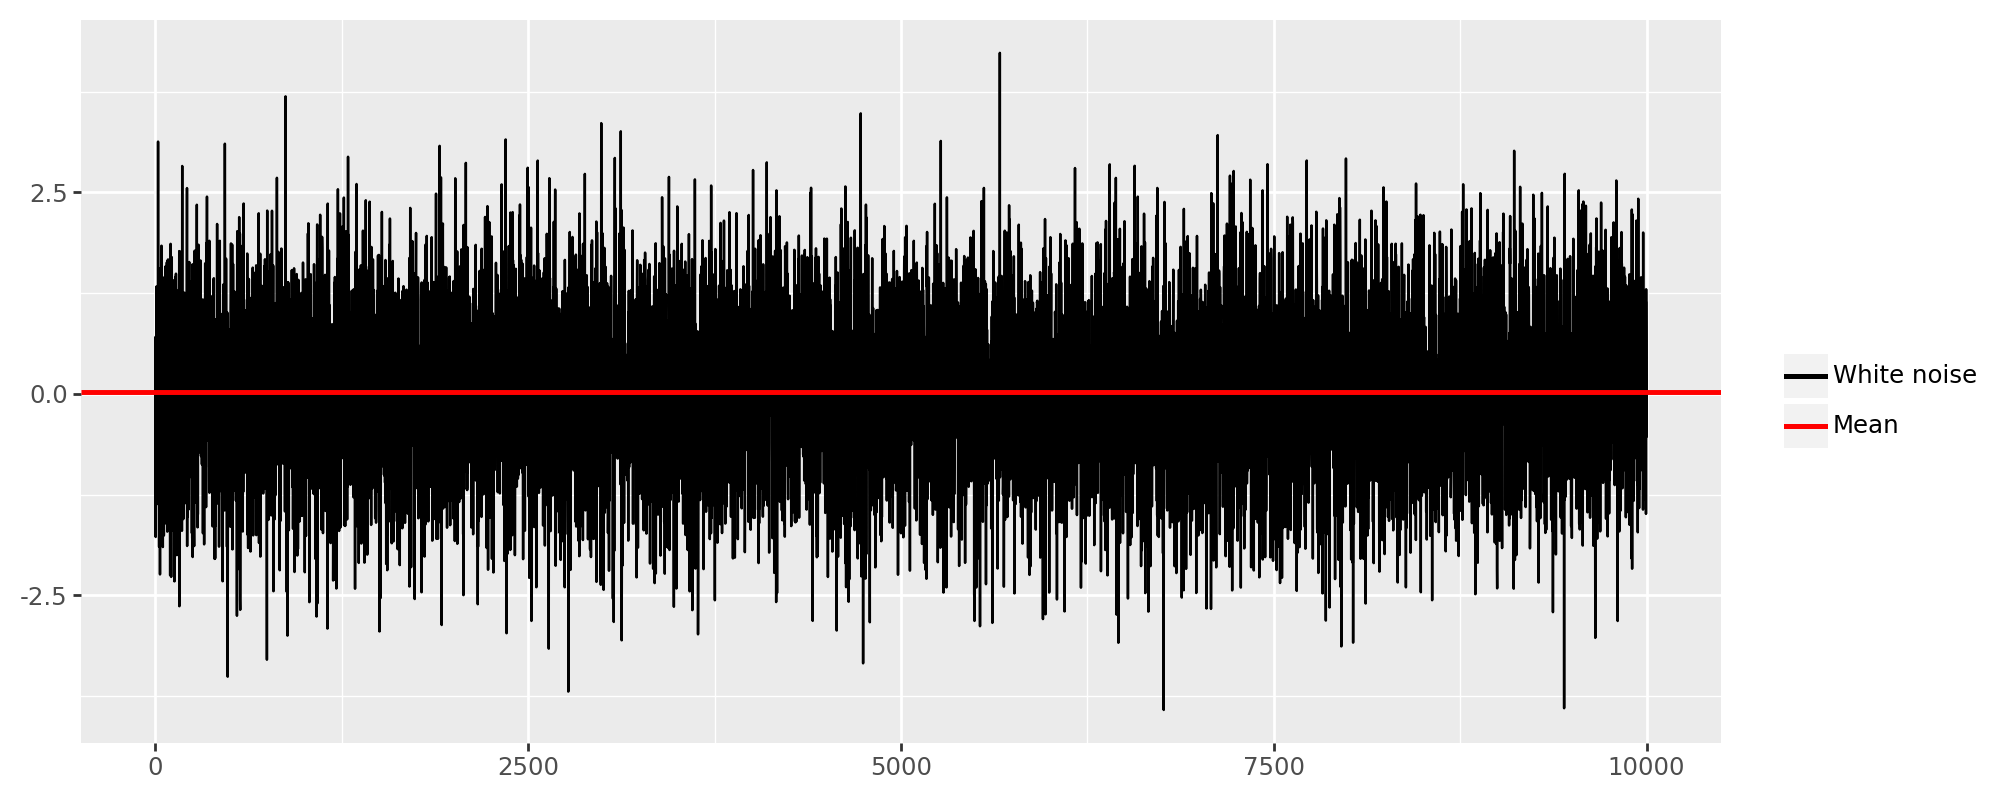

In [78]:
n = 10000
mu = 0
sigma = 1
white_noise = np.random.normal(mu, sigma, n)
(
    ggplot()
    + geom_line(aes(x=range(0, n), y=white_noise, color="'White noise'"))
    + geom_hline(aes(yintercept=white_noise.mean(), color="'Mean'"), size=1)
    + scale_color_manual(values={"White noise": "black", "Mean": "red"})
    + labs(color="")
    + theme(figure_size=(10, 4))
)

0 $\leq$ t $\leq$ 5000

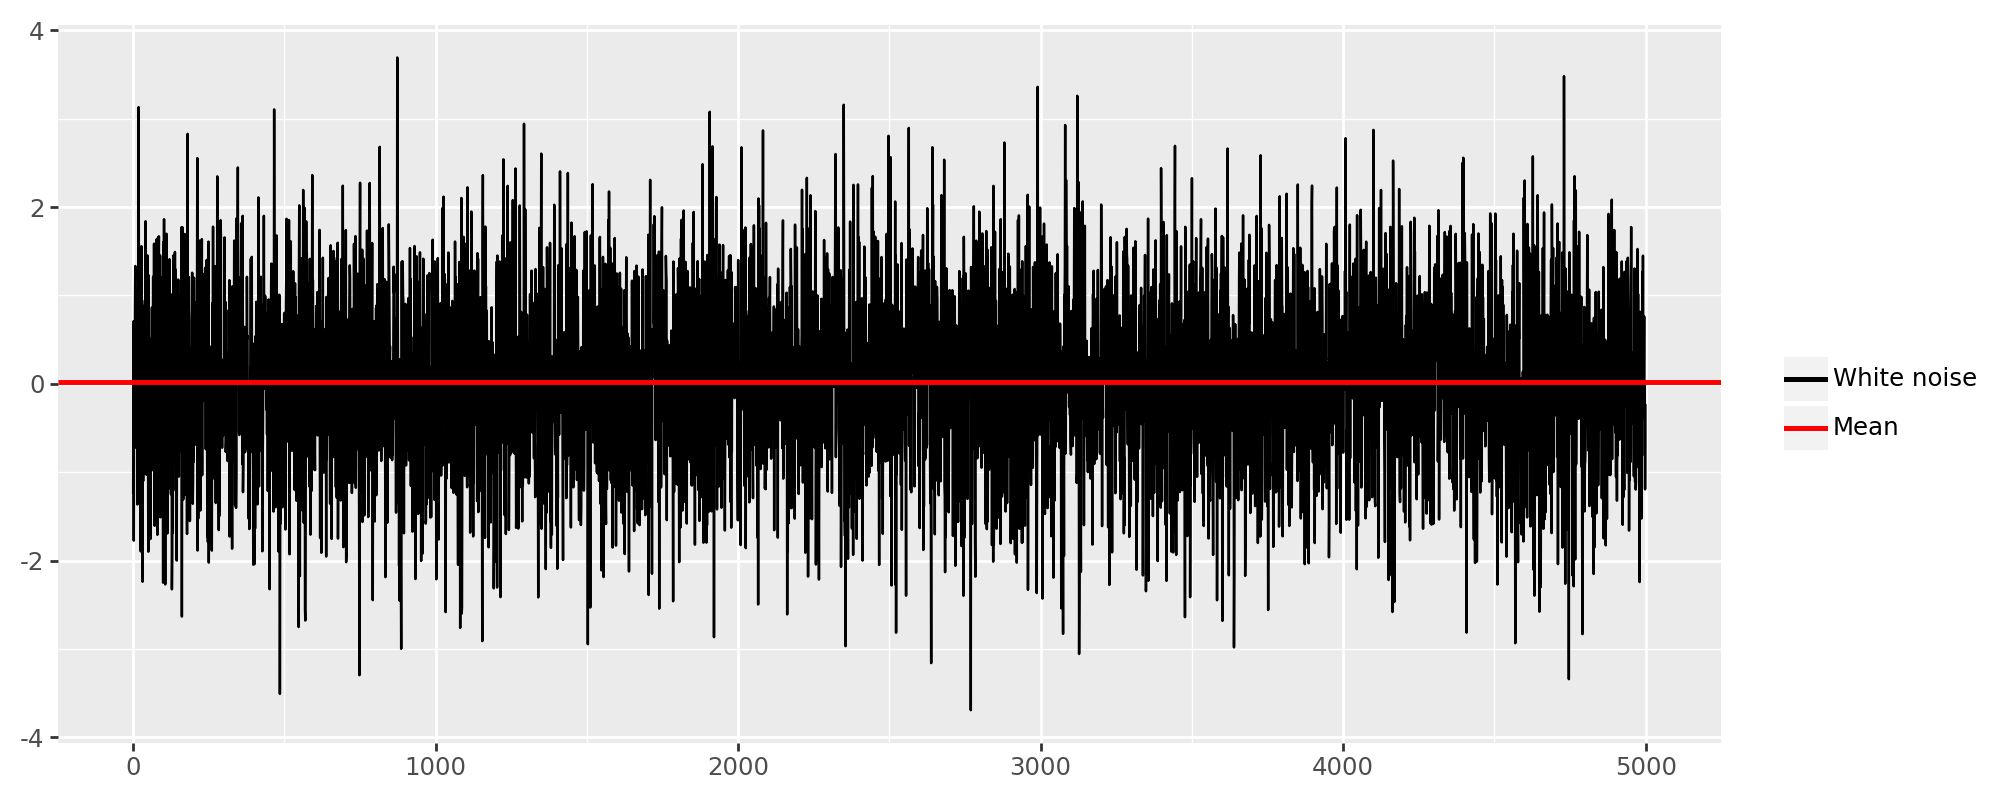

In [79]:
(
    ggplot()
    + geom_line(aes(x=range(0, 5000), y=white_noise[0:5000], color="'White noise'"))
    + geom_hline(aes(yintercept=white_noise[0:5000].mean(), color="'Mean'"), size=1)
    + scale_color_manual(values={"White noise": "black", "Mean": "red"})
    + labs(color="")
    + theme(figure_size=(10, 4))
)

5001 $\leq$ t $\leq$ 10000

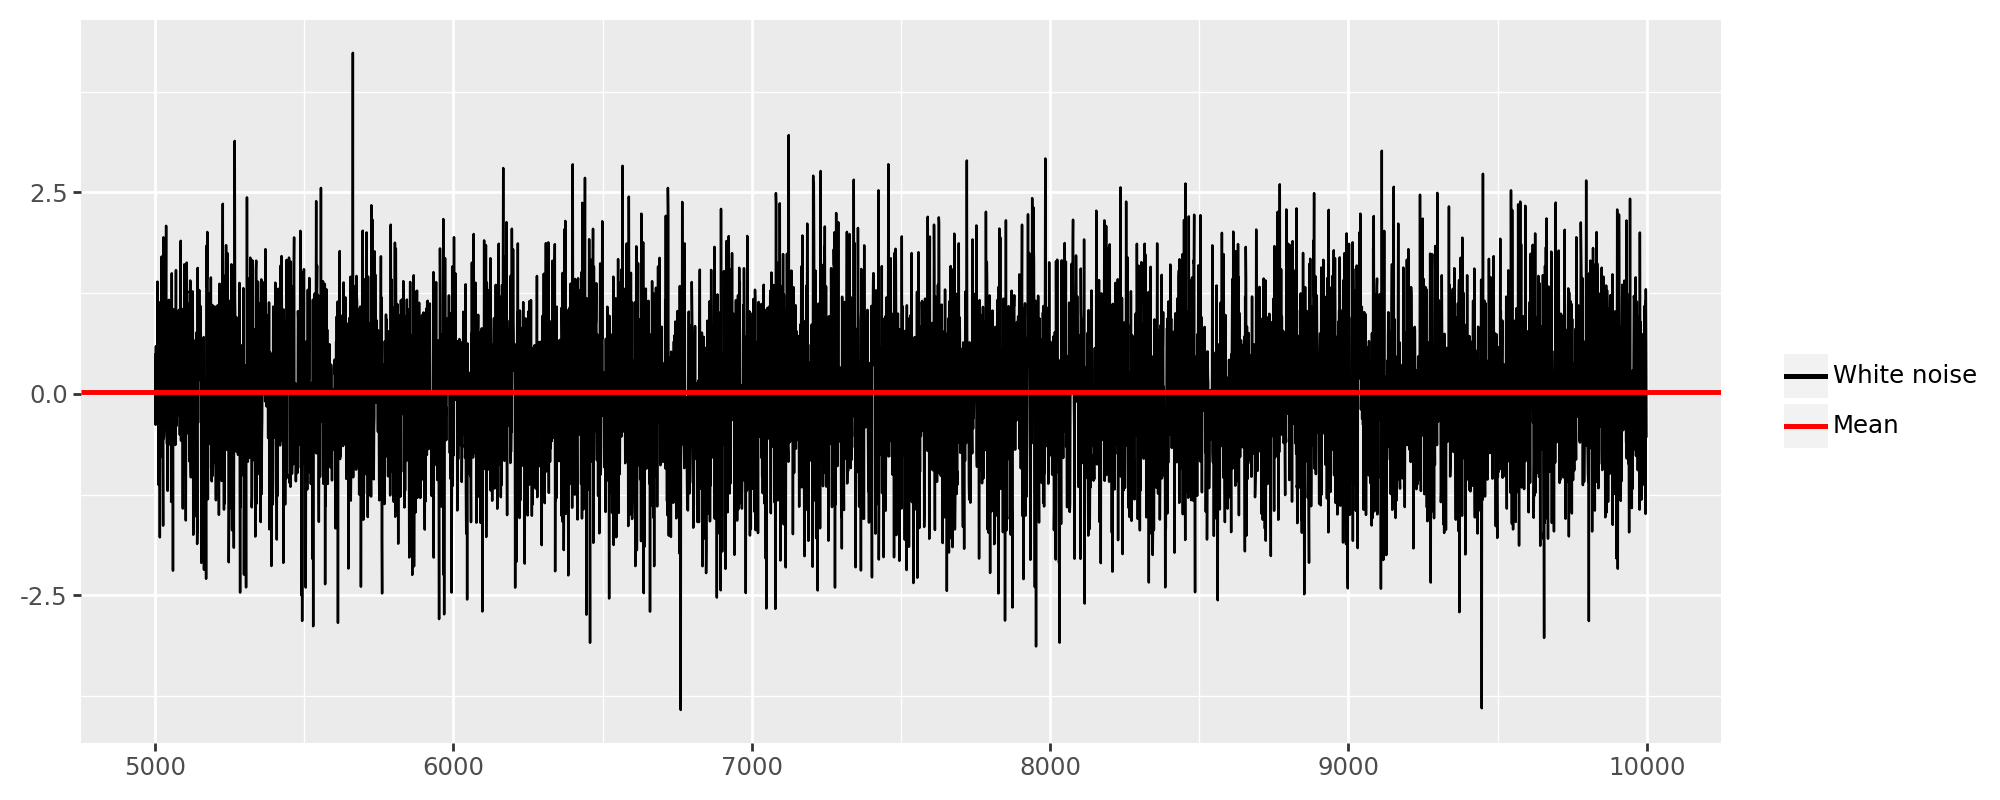

In [80]:
(
    ggplot()
    + geom_line(aes(x=range(5001, n), y=white_noise[5001:n], color="'White noise'"))
    + geom_hline(aes(yintercept=white_noise[5000:n].mean(), color="'Mean'"), size=1)
    + scale_color_manual(values={"White noise": "black", "Mean": "red"})
    + labs(color="")
    + theme(figure_size=(10, 4))
)

期待値 (平均) が範囲を変えても同じ

**定常なデータが分析しやすい理由**
- 分散とか期待値が時間によって変化しないから，単純に複数地点の平均とか分散を計算すれば特定の時間の推定量としてそれらを使える
- 統計的な時系列モデルを使える

## 非定常過程

- 定常過程に従わないデータのこと．

e.g.) 右肩上がりのトレンドがあるデータ -> 時間によって期待値が変化する

- 非定常なデータを定常なデータと同じように分析してもどう解釈していいかが難しい

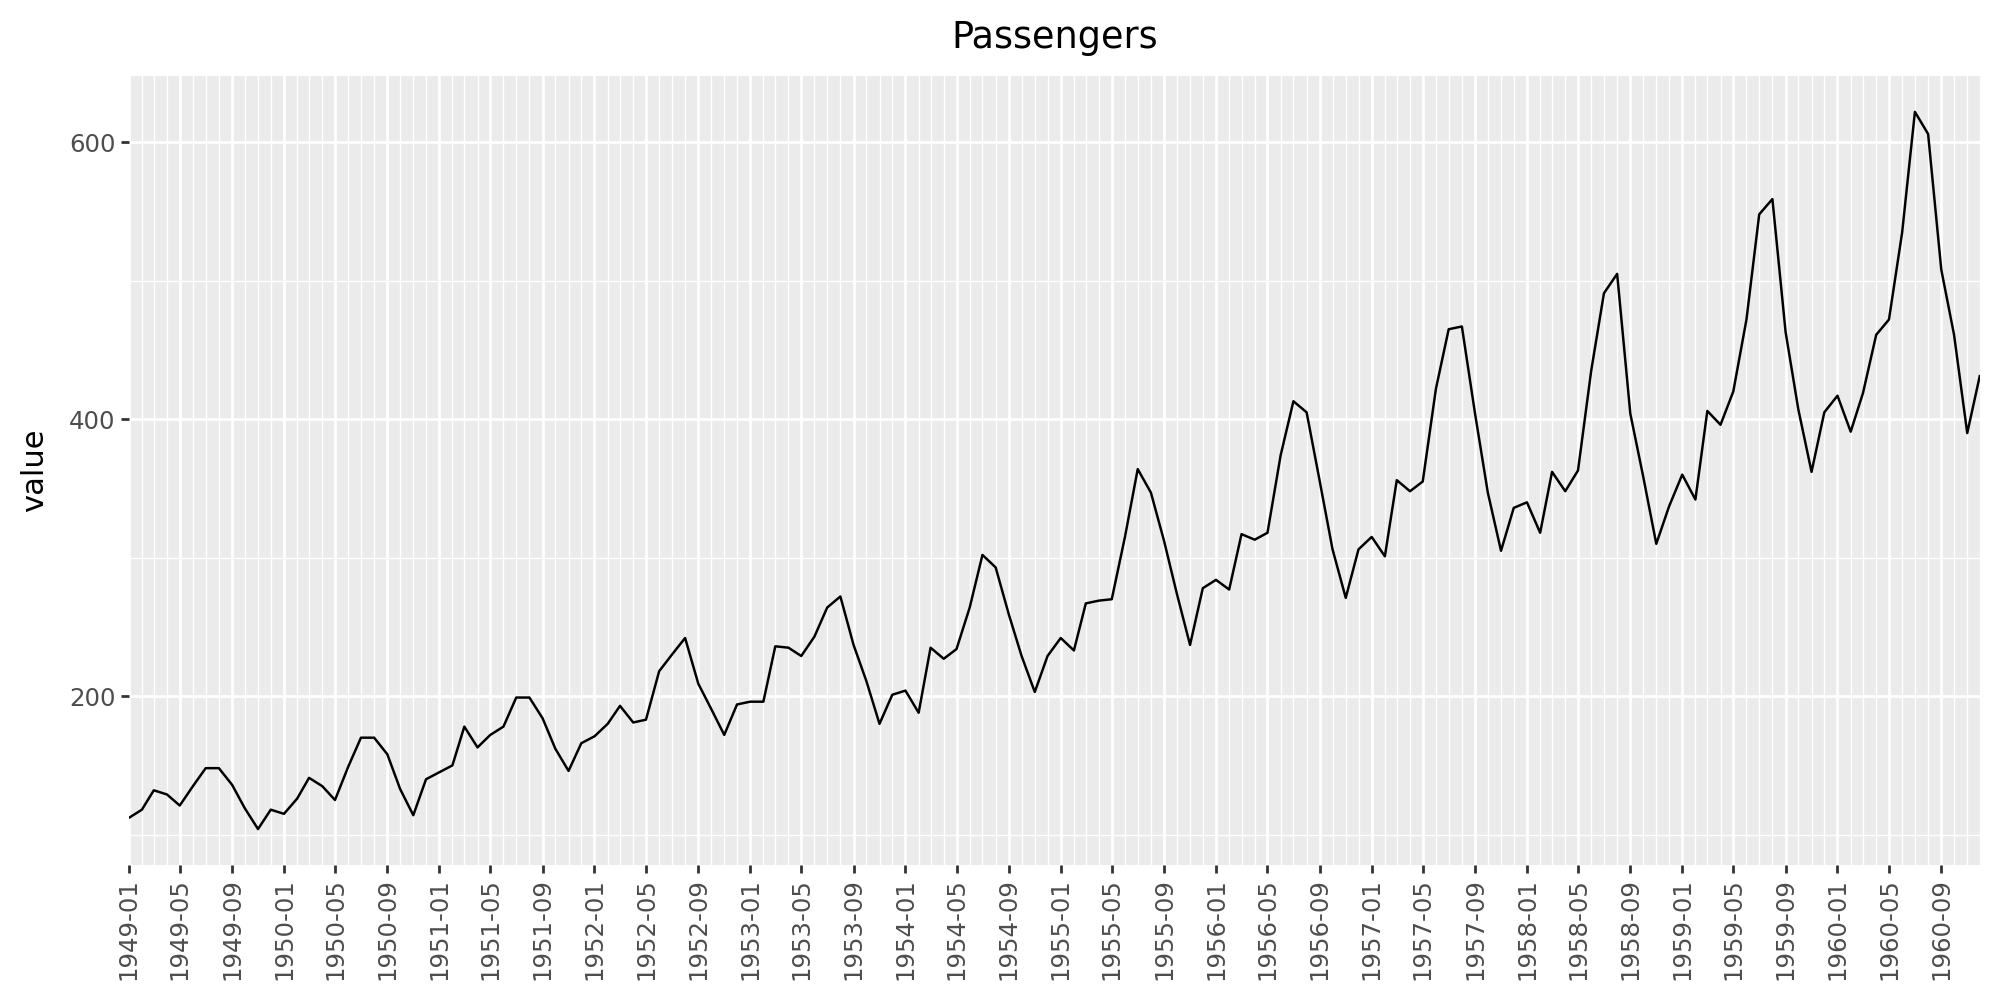

In [81]:
url = "https://www.salesanalytics.co.jp/591h"
df = pl.read_csv(url)
df = df.with_columns(pl.col("Month").str.strptime(pl.Date, "%Y-%m-%d"))
df = df.rename({"Month": "time", "Passengers": "value"})
(
    ggplot(aes(x=df["time"], y=(df["value"])))
    + geom_line()
    + labs(title="Passengers", y="value")
    + theme(figure_size=(10, 5), axis_text_x=element_text(rotation=90))
    + scale_x_date(
        # limits=(
        #     datetime(year=1949, month=1, day=1),
        #     datetime(year=1950, month=12, day=1),
        # ),
        date_labels="%Y-%m",
        date_breaks="4 month",
        expand=(0, 0),
        date_minor_breaks="1 month",
    )
)

右肩上がりのトレンドがあるし，だんだん分散が大きくなってるから非定常データといえそう

このデータを定常にできれば解釈が簡単になる

## 差分系列，単位根，和分過程

- 非定常なデータを定常なデータに変換したいときに挙げられる方法の一つとして差分がある．つまり

    $\Delta y_t = y_t - y_{t-1}$

    という操作をすることで定常なデータに変換しようとする．(差分系列と区別するためにもともとのデータを原系列と呼ぶ)．

    1回だけ差分をとったやつを1階差分と呼ぶ．2回だと2階差分．

- 原系列が非定常過程で，1階差分系列が定常過程の時，その過程を**単位根過程**と呼ぶ．

- d-1階差分をとった過程が非定常過程で，d階差分をとった過程が定常過程の時，その過程を**d次和分過程**と呼び I(d)と書く．

- 単位根過程は0階差分 (原系列)の時非定常，1階差分をとると定常な過程だから，単位根過程は I(1)過程であるのダ．原系列が定常な時は I(0)過程なのだ．

ランダムウォークは非定常過程として知られているから，それを定常過程にするために差分をとってみる

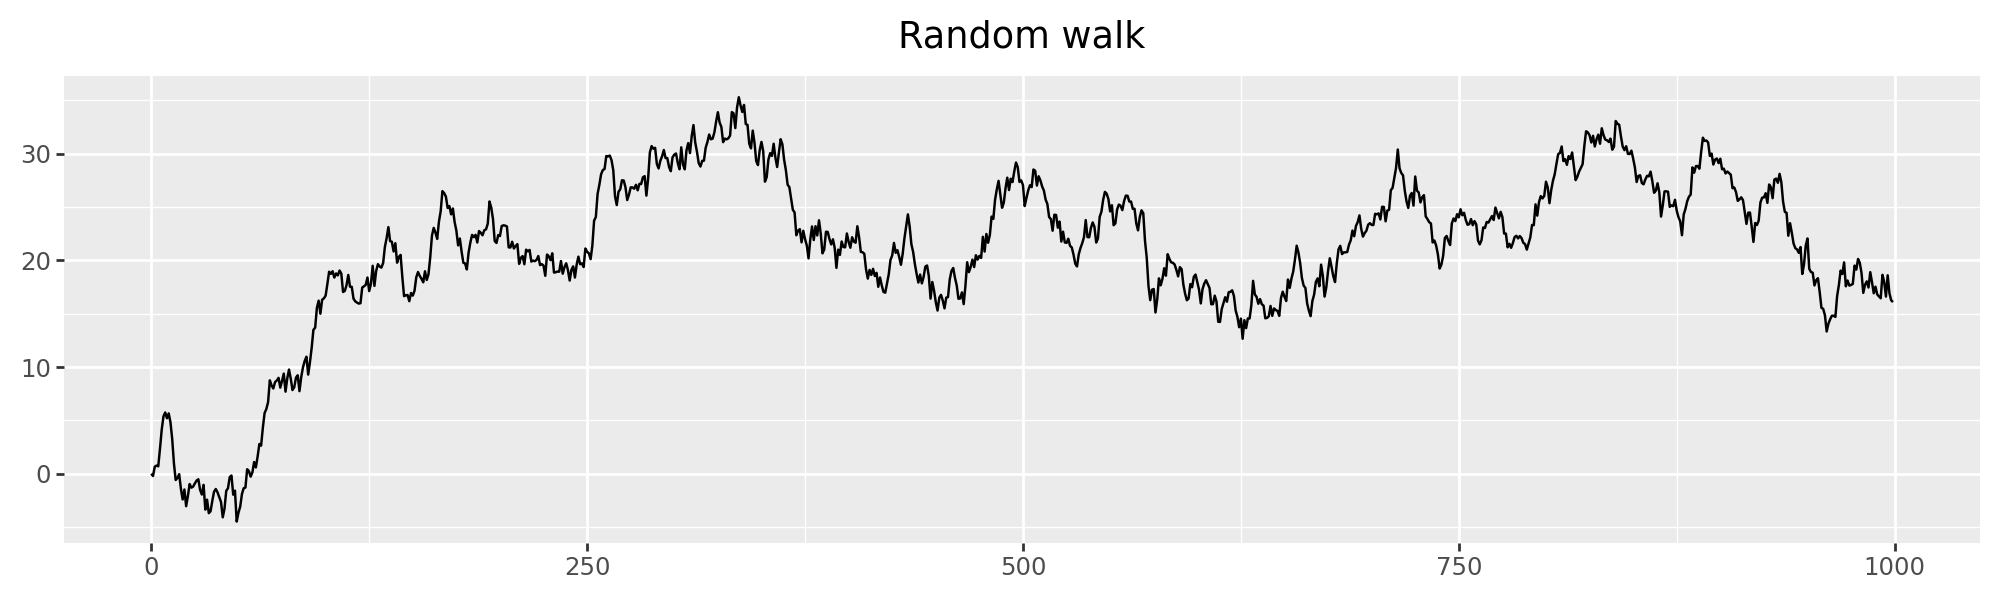

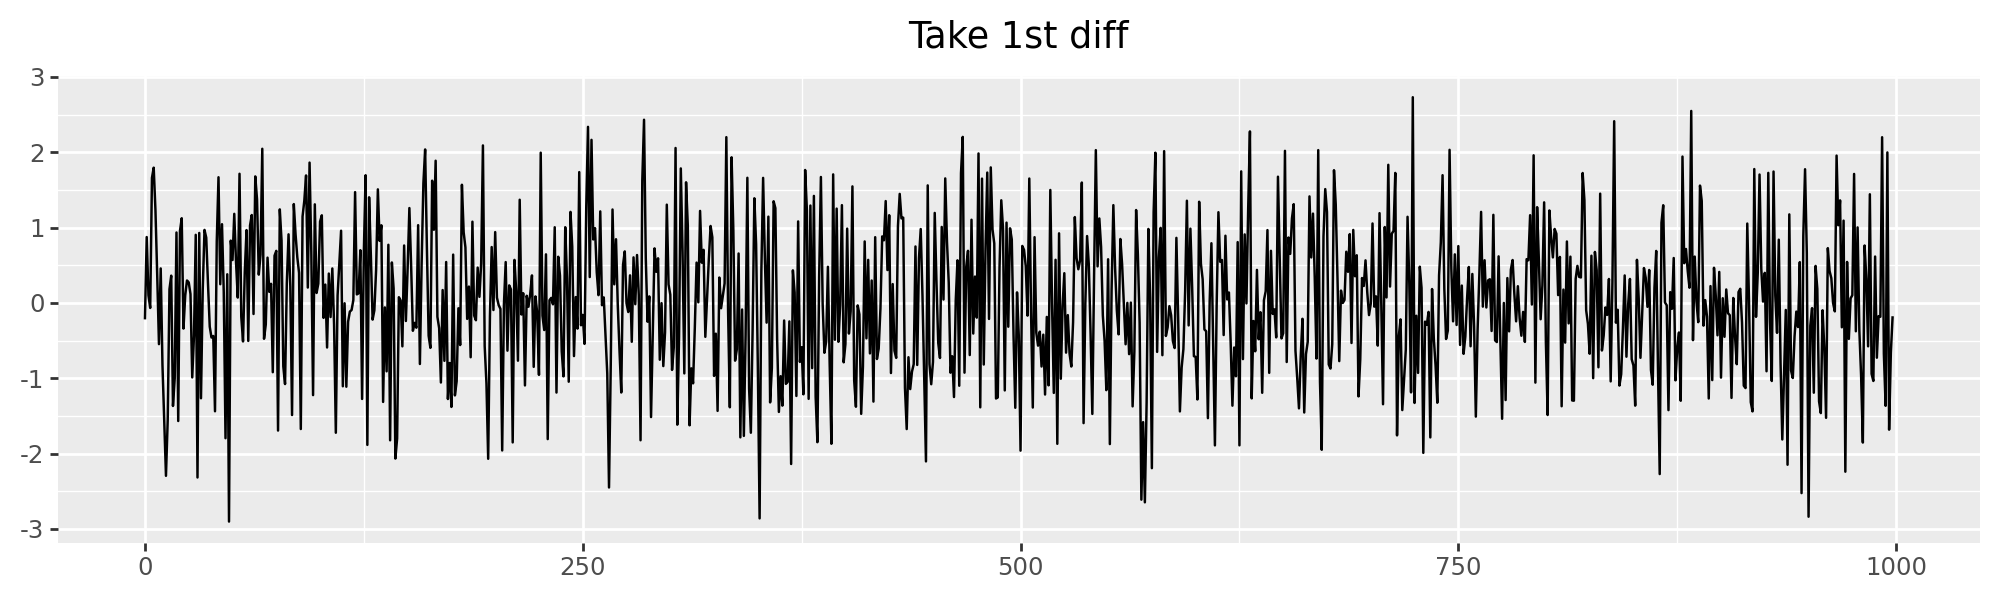

In [113]:
n = 1000
x0 = 0
noise = np.random.normal(0, 1, n)

random_walk = np.zeros(n)
random_walk[0] = x0

for i in range(1, n):
    random_walk[i] = random_walk[i - 1] + noise[i]

random_walk_diff = np.diff(random_walk, 1)

g1 = (
    ggplot()
    + geom_line(aes(x=range(0, n), y=random_walk))
    + labs(title="Random walk")
    + theme(figure_size=(10, 3))
)

g2 = (
    ggplot()
    + geom_line(aes(x=range(0, len(random_walk_diff)), y=random_walk_diff))
    + labs(title="Take 1st diff")
    + theme(figure_size=(10, 3))
)
print(g1, end="")
print(g2, end="")
del g1, g2 # clean up namespace

見た感じ1階差分系列は定常なデータっぽい．こんな感じのデータの変換によって分析を進める．

他に，対数をとったり対数をとってその差分をとったりする．

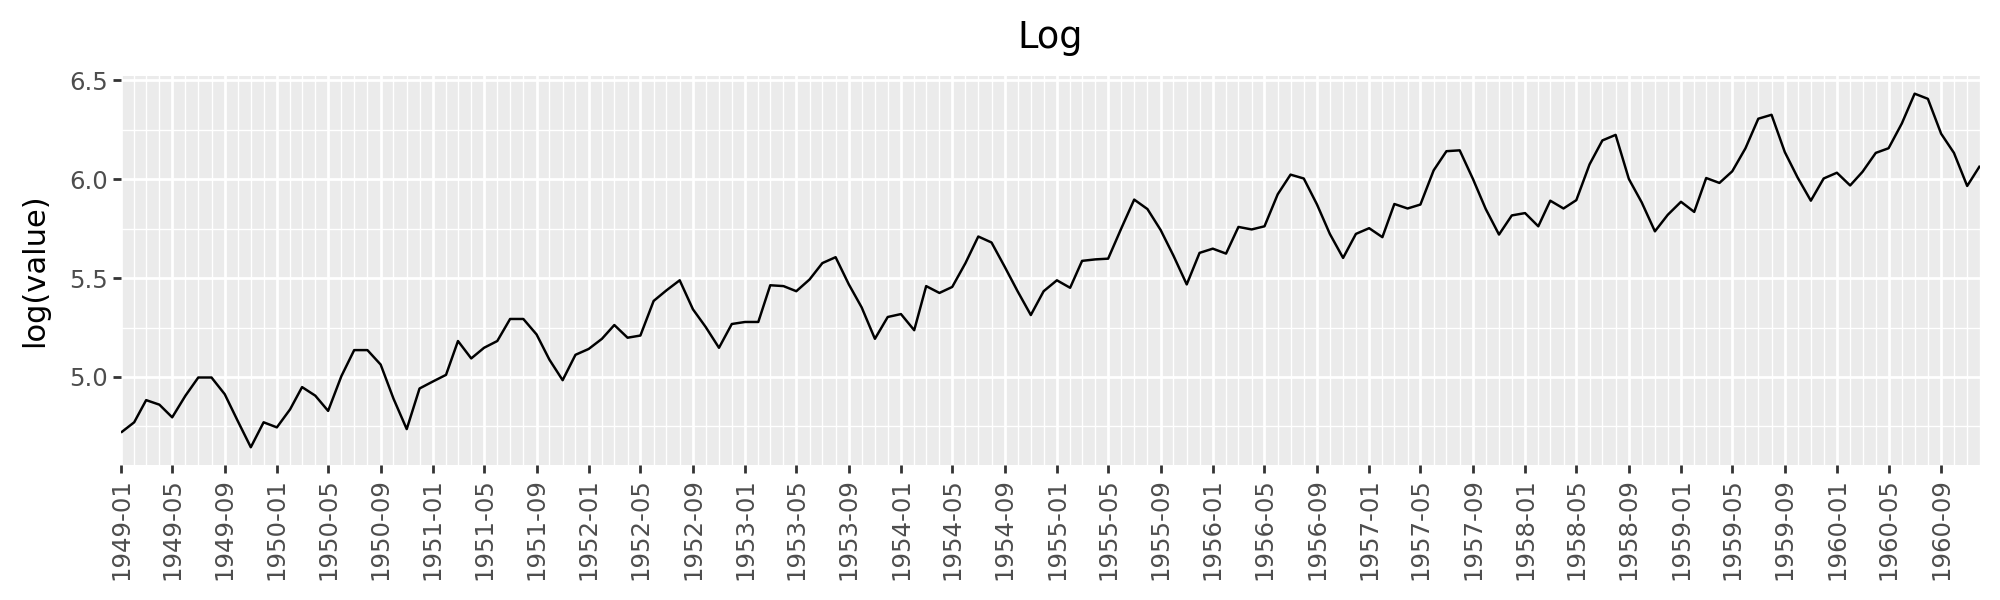

In [116]:
(
    ggplot(aes(x=df["time"], y=np.log(df["value"])))
    + geom_line()
    + labs(title="Log", y="log(value)")
    + theme(figure_size=(10, 3), axis_text_x=element_text(rotation=90))
    + scale_x_date(
        # limits=(
        #     datetime(year=1949, month=1, day=1),
        #     datetime(year=1950, month=12, day=1),
        # ),
        date_labels="%Y-%m",
        date_breaks="4 month",
        expand=(0, 0),
        date_minor_breaks="1 month",
    )
)

対数をとったことで分散が時間によってあまり変わらなくなった．この対数系列の差分をとってみると

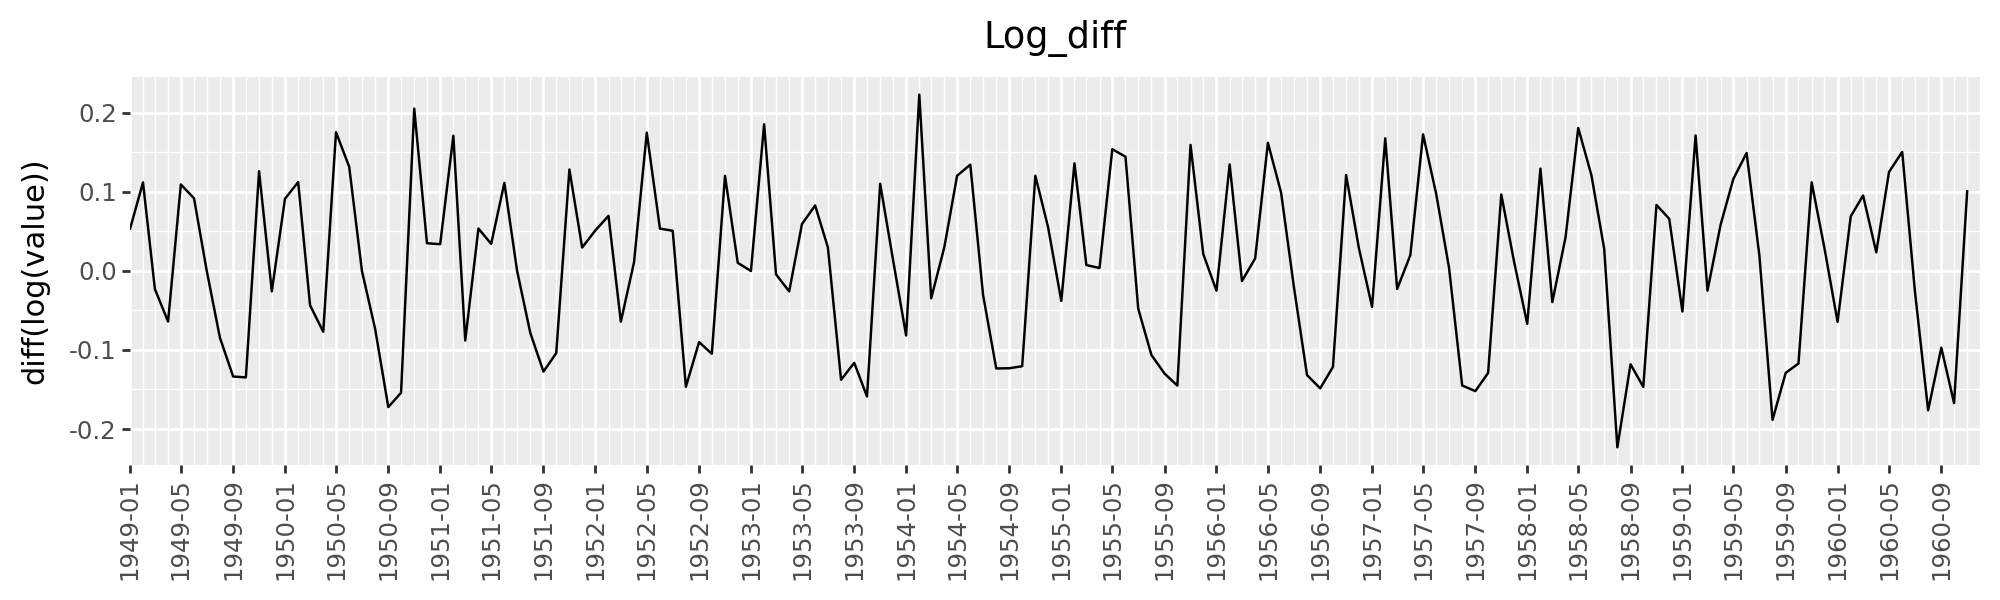

In [128]:
log_diff = np.diff(np.log(df["value"]), 1)
(
    ggplot(aes(x=df["time"][:-1], y=log_diff))
    + geom_line()
    + labs(title="Log_diff", y="diff(log(value))")
    + theme(figure_size=(10, 3), axis_text_x=element_text(rotation=90))
    + scale_x_date(
        # limits=(
        #     datetime(year=1949, month=1, day=1),
        #     datetime(year=1950, month=12, day=1),
        # ),
        date_labels="%Y-%m",
        date_breaks="4 month",
        expand=(0, 0),
        date_minor_breaks="1 month",
    )
)

対数をとった後差分をとる対数差分系列は近似的に，変化率とみなせるようで．

あとは，対数変換によって足し算が掛け算になるから解釈も変わってくるようで．あまりわからないけど．

季節性を取り除くための，季節階差なんてものもある．